INFO:root:Loading text and labels...
INFO:root:Text and label files loaded successfully.
INFO:root:Training SVM...


[LibSVM][LibSVM][LibSVM]

INFO:root:Evaluating SVM...


Metrics for class 'Negative':
  Precision: 0.5162
  Recall:    0.7397
  F1-Score:  0.6080
  Support:   799

Metrics for class 'Neutral':
  Precision: 0.6630
  Recall:    0.6097
  F1-Score:  0.6352
  Support:   1181

Metrics for class 'Positive':
  Precision: 0.7566
  Recall:    0.3585
  F1-Score:  0.4865
  Support:   477


Confusion Matrix:
[[591 198  10]
 [416 720  45]
 [138 168 171]]


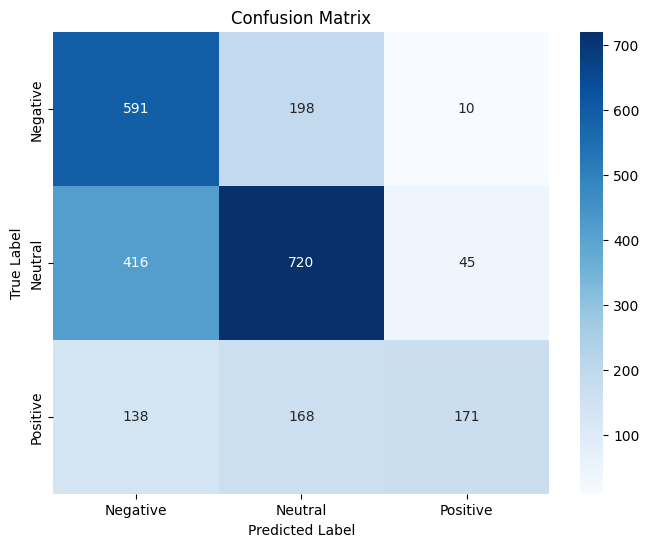


Confusion Matrix Explanation:
591 true negatives were correctly predicted as Negative.
198 negatives were misclassified as Neutral.
10 negatives were misclassified as Positive.
416 neutrals were misclassified as Negative.
720 true neutrals were correctly classified as Neutral.
45 neutrals were misclassified as Positive.
138 positives were misclassified as Negative.
168 positives were misclassified as Neutral.
171 true positives were correctly classified as Positive.
Overall Accuracy: 0.6032
ROC-AUC for class 'Negative': 0.8253
ROC-AUC for class 'Neutral': 0.7158
ROC-AUC for class 'Positive': 0.8393


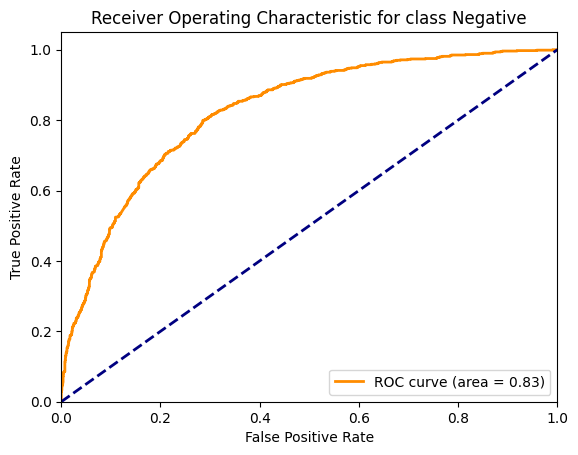

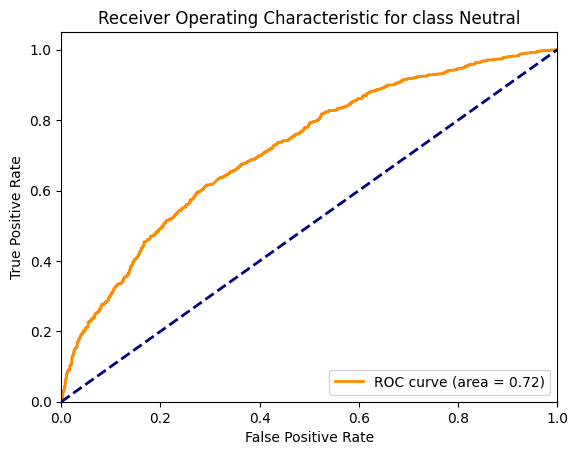

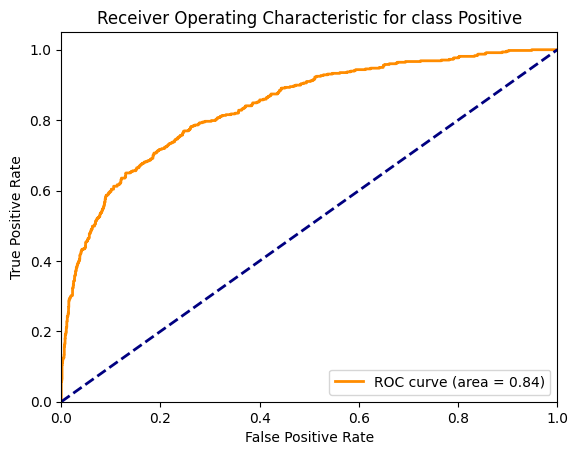

In [1]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_curve, auc, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm
import logging
import seaborn as sns

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

# Load the data
logger.info("Loading text and labels...")
with open('sentiment-data/test_text.txt', 'r', encoding='utf-8') as file:
    texts = file.readlines()

with open('sentiment-data/test_labels.txt', 'r', encoding='utf-8') as file:
    labels = [int(label.strip()) for label in file.readlines()]

logger.info("Text and label files loaded successfully.")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Convert text data into TF-IDF features
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# Binarize the labels for ROC-AUC calculation
y_train_bin = label_binarize(y_train, classes=[0, 1, 2])
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

# Initialize the classifier
clf = OneVsRestClassifier(SVC(kernel='linear', probability=True, verbose=True))

# Train the classifier
logger.info("Training SVM...")
clf.fit(X_train, y_train_bin)

# Predict and calculate scores
logger.info("Evaluating SVM...")
y_pred_bin = clf.predict(X_test)
y_pred = y_pred_bin.argmax(axis=1)  # Get the predicted class labels
y_score = clf.predict_proba(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average=None, labels=[0, 1, 2])

# Print metrics
class_names = ['Negative', 'Neutral', 'Positive']
for i, class_name in enumerate(class_names):
    print(f"Metrics for class '{class_name}':")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall:    {recall[i]:.4f}")
    print(f"  F1-Score:  {f1[i]:.4f}")
    print(f"  Support:   {support[i]}")
    print()

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display confusion matrix
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show(block=False)

# Print a detailed explanation of the confusion matrix
print("\nConfusion Matrix Explanation:")
print(f"{conf_matrix[0, 0]} true negatives were correctly predicted as Negative.")
print(f"{conf_matrix[0, 1]} negatives were misclassified as Neutral.")
print(f"{conf_matrix[0, 2]} negatives were misclassified as Positive.")
print(f"{conf_matrix[1, 0]} neutrals were misclassified as Negative.")
print(f"{conf_matrix[1, 1]} true neutrals were correctly classified as Neutral.")
print(f"{conf_matrix[1, 2]} neutrals were misclassified as Positive.")
print(f"{conf_matrix[2, 0]} positives were misclassified as Negative.")
print(f"{conf_matrix[2, 1]} positives were misclassified as Neutral.")
print(f"{conf_matrix[2, 2]} true positives were correctly classified as Positive.")

# Calculate ROC-AUC
fpr = {}
tpr = {}
roc_auc = {}
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Print ROC-AUC
print(f"Overall Accuracy: {accuracy:.4f}")
for i in range(3):
    print(f"ROC-AUC for class '{class_names[i]}': {roc_auc[i]:.4f}")

# Plot ROC curve
for i in range(3):
    plt.figure()
    plt.plot(fpr[i], tpr[i], color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic for class {class_names[i]}')
    plt.legend(loc="lower right")
    plt.show(block=False)
